In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('categorized_particles.csv')
df.type.values.reshape(-1, 1).shape

(114708, 1)

In [3]:
X=df.drop(['type','step','experiment'], axis=1)
Y=df['type'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel

rfc = RandomForestClassifier(criterion = 'gini', max_depth=None, random_state = 0) 
#criterion = 'entropy' for shannon entropy to minimize log loss (for classification)

"""
random state - set to either 0 or 42 is common, locks in the seed for a random number generator so 
the same string of random numbers can be reproduced in the future. Used to create randomness in data selection
and feature selection for each tree

criterion - gini is default, entropy also used. Both are for classification. 

reduce tree depth to simplify model and help with overfitting

need to evaluate on training set - 100% on training is overfitting, low bias, high variance
"""

#fit model to training data with all columns except strings
rfc.fit(X_train, Y_train)

# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)

# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)

accuracy of training predition = 1.0
accuracy of testing predition = 0.9962223578298899
[[    5     2     0     5     0     7     0     0     0     5     0     0]
 [    0 12533     0     3     0     1     0     5     0     0     0     0]
 [    0     3     1     0     0     0     0     1     0     1     0     0]
 [    0     1     0  1437     4     1     0     4     0     1     0     0]
 [    0     3     0    17   910     0     0    10     0     0     0     0]
 [    1     0     0     3     0   113     0     3     0     0     0     0]
 [    0     0     0     0     0     0   505     0     0     0     0     0]
 [    0     3     0     0    27     0     0 17392     0     0     0     0]
 [    0     0     0     0     5     1     0     6     0     1     0     0]
 [    1     0     0     0     0     0     0     0     0  1383     0     0]
 [    0     0     0     1     0     0     0     0     0     1     0     0]
 [    0     0     0     0     0     0     0     0     0     3     0     4]]


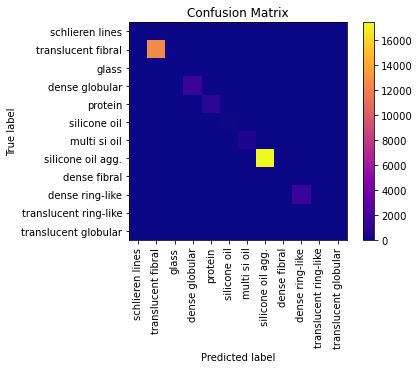

In [5]:
#model evaluation

from sklearn.metrics import ConfusionMatrixDisplay

score_train=rfc.score(X_train, Y_train) #, sample_weight=None)
score_test=rfc.score(X_test, Y_test) #, sample_weight=None)

#if performance metrics on training data is much better than on test data, we are overfitting

print("accuracy of training predition =", score_train) 
print("accuracy of testing predition =", score_test)

types=df['type'].unique()
title_options = [("Confusion Matrix", None),("Normalized Confusion Matrix","true")] 

disp=ConfusionMatrixDisplay.from_estimator(rfc, X_test, Y_test, display_labels=types, include_values=False, cmap=plt.cm.plasma,
                                           xticks_rotation='vertical')
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

Feature importances:  [0.20388491 0.00835873 0.04425944 0.00580464 0.02035178 0.02481053
 0.05473941 0.07283496 0.03284912 0.0330151  0.03896976 0.14631787
 0.04126707 0.25933925 0.00142805 0.00118604 0.0049462  0.00563715
 0.        ]
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, 'Visualizing Important Features')

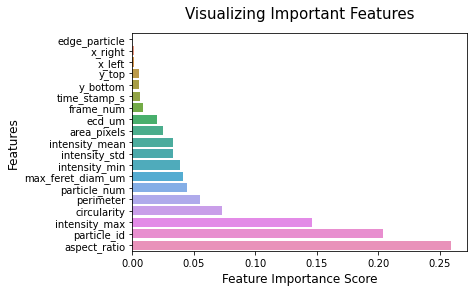

In [6]:
import seaborn as sns

"""
built-in feature importance attribute that calculates feature importance scores for 
each feature based on the quality of a node split in trees (gini)

This can be used to determine what features can be dropped from the model 
"""
#analyze feature importance
feature_importance = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=True)

print('Feature importances: ', rfc.feature_importances_)
print(sns.barplot(x=feature_importance, y=feature_importance.index))
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Important Features", fontsize=15, pad=15)

In [7]:
feature_selector = SelectFromModel(rfc, threshold = 0.05)
important_features = feature_selector.fit_transform(X_train, Y_train)
test_imp_feat = feature_selector.fit_transform(X_test, Y_test)

rfc2 = RandomForestClassifier(criterion = 'gini', max_depth=None, random_state = 0) 

rfc2.fit(important_features, Y_train)

# Evaluating on Training set
rfc_pred_train = rfc2.predict(important_features)

# Evaluating on Test set
rfc_pred_test = rfc2.predict(test_imp_feat)

[[    1     2     0     6     0     3     0     0     0    11     0     1]
 [    2 12494     0     4     2     3     0    37     0     0     0     0]
 [    0     3     0     1     0     0     0     0     0     1     0     1]
 [    0    12     0  1421     5     0     0     5     0     4     0     1]
 [    0     3     0    12   913     1     0    11     0     0     0     0]
 [    0    25     0     6    17    65     0     4     0     3     0     0]
 [    0     0     0     0     0     0   503     0     0     2     0     0]
 [    0    56     0     6    26     2     0 17332     0     0     0     0]
 [    0     0     0     0     6     1     0     5     0     1     0     0]
 [    1     0     0     3     0     0     1     0     0  1378     0     1]
 [    0     0     0     1     0     0     0     0     0     1     0     0]
 [    0     0     0     1     0     0     0     1     0     2     0     3]]


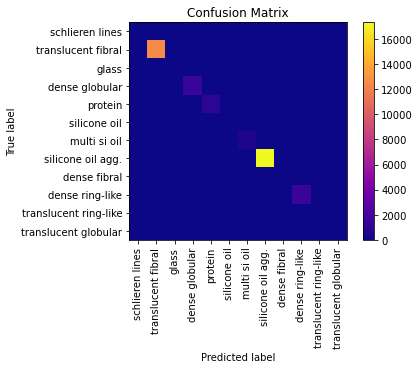

In [10]:

score_train_less_features=rfc2.score(important_features, Y_train)
score_test_less_features=rfc2.score(test_imp_feat, Y_test) 

types=df['type'].unique()
title_options = [("Confusion Matrix", None),("Normalized Confusion Matrix","true")] 

disp=ConfusionMatrixDisplay.from_estimator(rfc2, test_imp_feat, Y_test, display_labels=types, include_values=False, 
                                           cmap=plt.cm.plasma, xticks_rotation='vertical')
disp.ax_.set_title("Confusion Matrix")

print(disp.confusion_matrix)

#for title, normalize in title_options:
#    disp = ConfusionMatrixDisplay.from_estimator(
#        rfc,
#        X_test,
#        Y_test,
#        display_labels=types,
#        cmap=plt.cm.Blues,
#        normalize=normalize,)
#    disp.ax_.set_title(title)

#    print(title)
#    print(disp.confusion_matrix)


In [28]:
#compare accuracy of max features vs less features
#less features is slightly less accurate on testing

print("max features scores")
print("--------------------------")
print("train ", score_train) 
print("test ", score_test)
print("--------------------------")
print("optimized features scores")
print("--------------------------")
print("train ", score_train_less_features) 
print("test ", score_test_less_features)
print("--------------------------")

max features scores
--------------------------
train  1.0
test  0.9962223578298899
--------------------------
optimized features scores
--------------------------
train  0.9999750918488075
test  0.991195187865051
--------------------------


In [58]:
count=0

for i, estimate in enumerate(rfc_pred_test):
    if rfc_pred_test[i]==Y_test[i]:
        count=count+1
    else:
        count=count
print((count/len(rfc_pred_test))*100)

99.57574172551071


In [ ]:
magic functions: timeit # to calculate computing time
%timeit(command)

In [ ]:
#for loop for anything used twice

#function for anything used more than 2 times

In [ ]:
types=df['type'].unique()
grouped_type=df.groupby("type")

list1=[]

for i in range(11):
    list1.append(grouped_type.get_group(types[i]))

for idx, name in enumerate(types):
    for i in range(11):
        list1.append(grouped_type.get_group(types[i]))
    print("number of", name , "=", list1[idx].shape[0])

In [ ]:

fig=plt.figure(figsize=(8,6))
ax1=fig.add_subplot(1,1,1)

colors=['red','blue','green','k','orange','purple','cyan','magenta','lavender','yellow','pink','brown']

#want to replace this for loop with a function that can be input with any number of particle names or indexes

for i in range(len(types)):
    ax1.scatter(list1[i]['max_feret_diam_um'], list1[i]['circularity'], s=0.1, color = colors[i], label=types[i])

ax1.set_xlabel('max feret diamter (um)')
ax1.set_ylabel('circularity')

legend=plt.legend(markerscale=15)

plt.show()